<a href="https://colab.research.google.com/github/abnermsousa/modelo_analise_metricas_RFV/blob/main/Desafio_7_Crie_um_modelo_de_an%C3%A1lise_das_m%C3%A9tricas_RFV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
%pip install sidetable

In [ ]:
  #Importando bibliotecas
import numpy as np
import pandas as pd
import sidetable

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, scale
from sklearn.preprocessing import MinMaxScaler


from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from yellowbrick.cluster import kelbow_visualizer

In [ ]:
# Configuração do tema do Seaborn
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

In [ ]:
#a. Carregue a base de dados;
df = pd.read_csv('data.csv', encoding='latin1')
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
# Descrição estatística dos dados
print(df.describe())
print(df.info())

            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
d

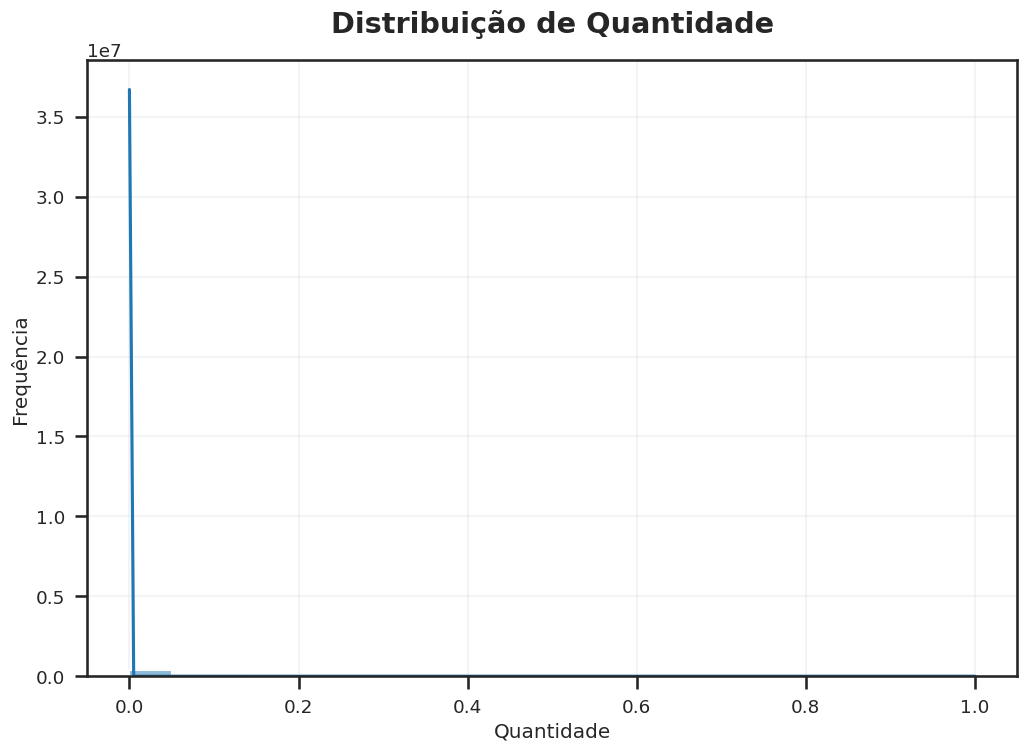

In [ ]:
# Visualização das distribuições
sns.histplot(df['Quantity'], kde=True, bins=20)
plt.title('Distribuição de Quantidade')
plt.xlabel('Quantidade')
plt.ylabel('Frequência')
plt.show()


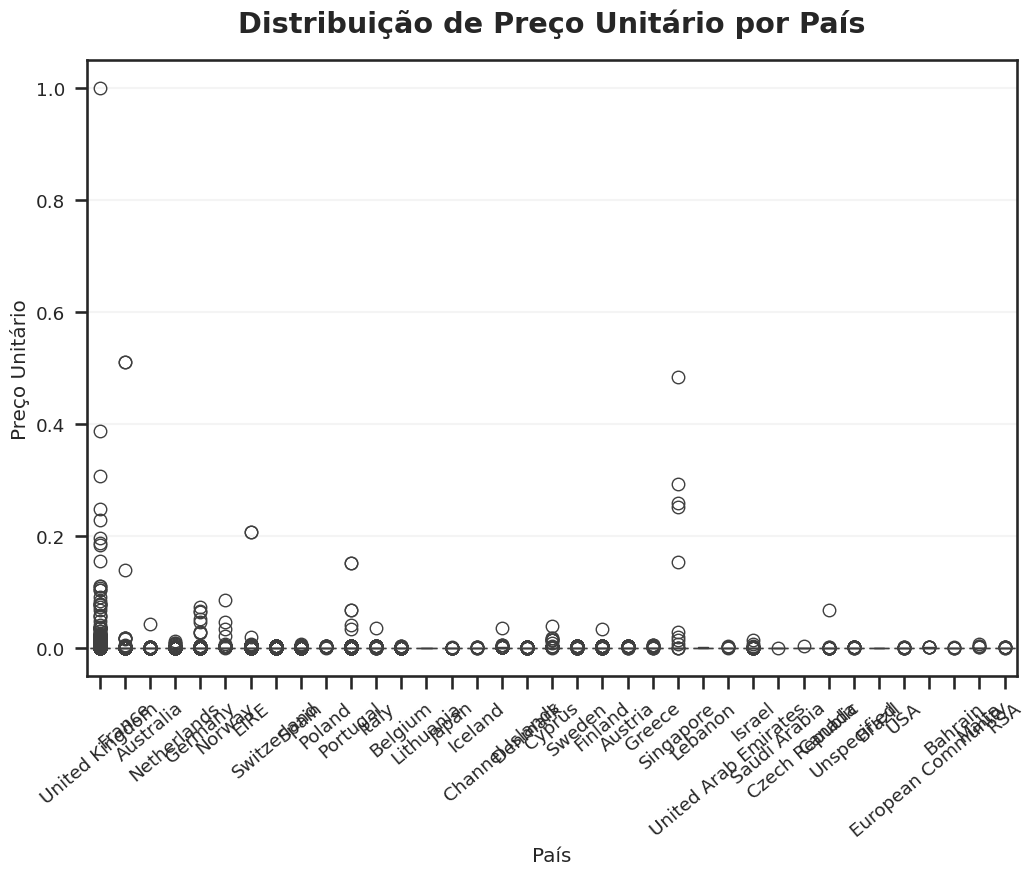

In [ ]:
# Visualização das distribuições
sns.boxplot(x='Country', y='UnitPrice', data=df)
plt.title('Distribuição de Preço Unitário por País')
plt.xlabel('País')
plt.ylabel('Preço Unitário')
plt.xticks(rotation=40)
plt.show()

In [ ]:
# Verificar dados nulos
print(df.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [ ]:
# Verificar dados duplicados
print(df.duplicated().sum())

5268


In [ ]:
# Preencher dados nulos na coluna Description com uma string vazia
df['Description'].fillna('', inplace=True)

In [ ]:
# Remover linhas com dados nulos na coluna CustomerID
df.dropna(subset=['CustomerID'], inplace=True)

In [ ]:
# Remover transações com quantidade negativa
df = df[df['Quantity'] >= 0]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
# Remover transações com preço unitário negativo
df = df[df['UnitPrice'] >= 0]

In [ ]:
# Remover linhas duplicadas
df.drop_duplicates(inplace=True)

In [ ]:
# Inicializar o scaler
scaler = MinMaxScaler()

In [ ]:
# Normalizar as colunas 'Quantity' e 'UnitPrice'
df[['Quantity', 'UnitPrice']] = scaler.fit_transform(df[['Quantity', 'UnitPrice']])

In [ ]:
# Revisar as colunas disponíveis
print(df.columns)

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


In [ ]:
# Selecionar variáveis relevantes
df_selected = df[['Quantity', 'UnitPrice']]

In [ ]:
# Verificar as primeiras linhas do DataFrame selecionado
print(df_selected.head())

   Quantity  UnitPrice
0  0.000062   0.000313
1  0.000062   0.000416
2  0.000086   0.000338
3  0.000062   0.000416
4  0.000062   0.000416


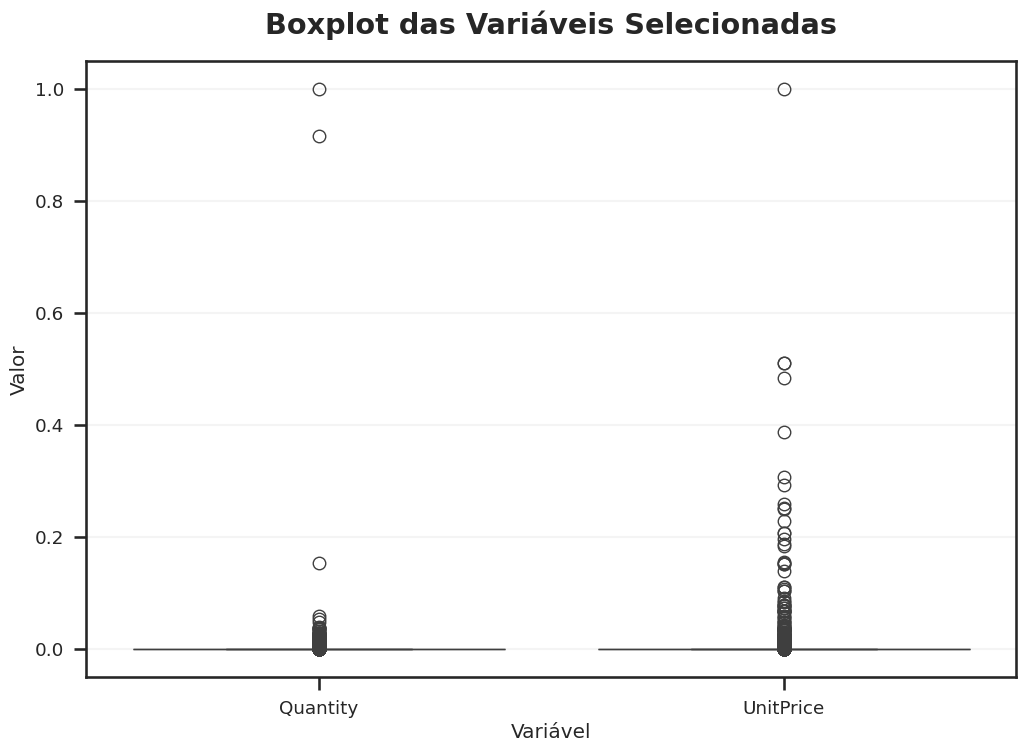

In [ ]:
# Verificar a presença de outliers
sns.boxplot(data=df_selected)
plt.title('Boxplot das Variáveis Selecionadas')
plt.xlabel('Variável')
plt.ylabel('Valor')
plt.show()

In [ ]:
# Encontrar a quantidade ideal de clusters usando o método Elbow
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_selected)
    inertia.append(kmeans.inertia_)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

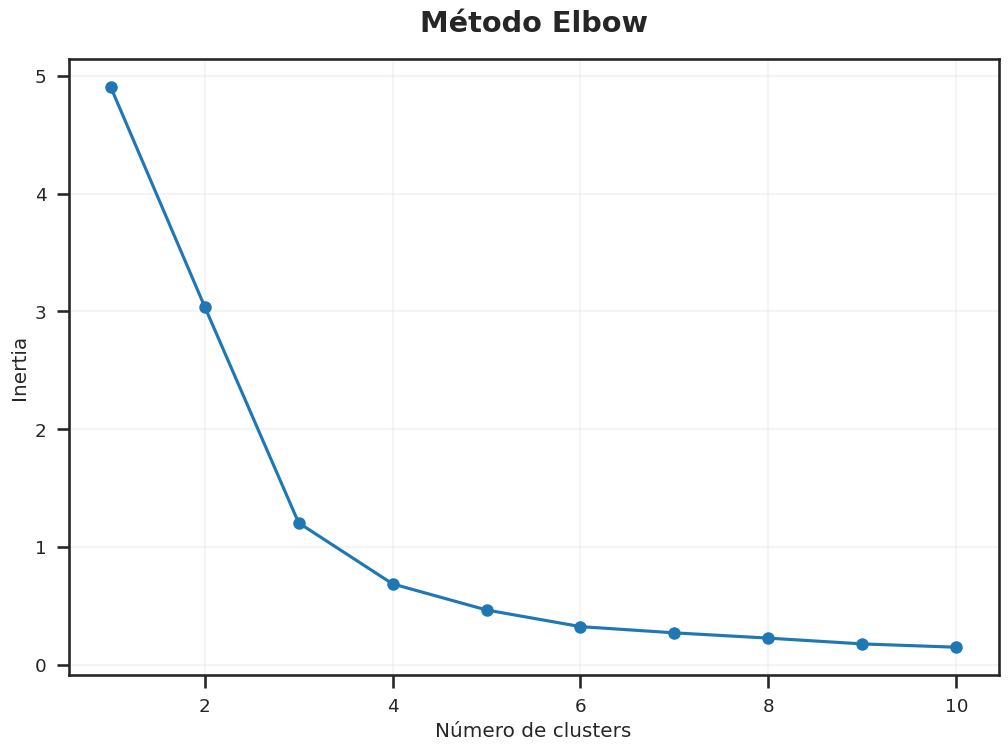

In [ ]:
# Plotar o método Elbow
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método Elbow')
plt.xlabel('Número de clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
# Implementar o algoritmo KMeans com o número ideal de clusters
k = 3  # Número ideal de clusters identificado
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(df_selected)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

In [ ]:
# Adicionar os rótulos dos clusters ao DataFrame
df_selected['Cluster'] = kmeans.labels_

<ipython-input-46-e6adeed41175>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Cluster'] = kmeans.labels_


In [ ]:
# Visualizar as primeiras linhas do DataFrame com os rótulos dos clusters
print(df_selected.head())

   Quantity  UnitPrice  Cluster
0  0.000062   0.000313        0
1  0.000062   0.000416        0
2  0.000086   0.000338        0
3  0.000062   0.000416        0
4  0.000062   0.000416        0


In [ ]:
# Estatísticas descritivas de cada cluster
cluster_stats = df_selected.groupby('Cluster').agg({'Quantity': ['mean', 'std'],
                                                    'UnitPrice': ['mean', 'std', 'count']})
print(cluster_stats)

         Quantity           UnitPrice                  
             mean       std      mean       std   count
Cluster                                                
0        0.000145  0.000586  0.000370  0.001018  392714
1        0.958145  0.059192  0.000192  0.000090       2
2        0.000000  0.000000  0.341765  0.209531      16


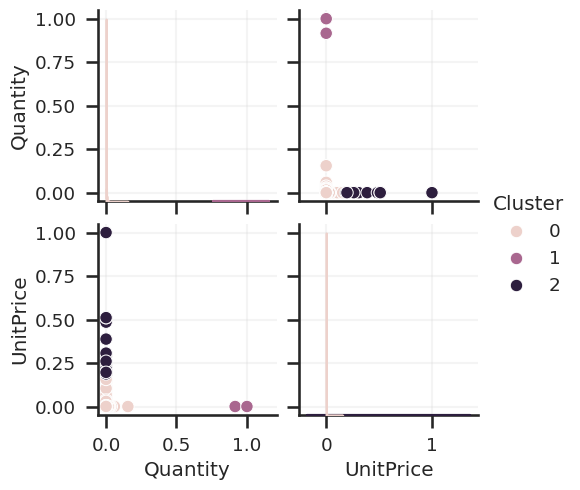

In [ ]:
# Visualização das distribuições das variáveis em cada cluster
sns.pairplot(data=df_selected, hue='Cluster')
plt.show()


**Cluster 0:**

Este cluster parece representar a maioria dos clientes, com uma quantidade média de produtos relativamente baixa e um preço unitário médio baixo. Isso pode indicar transações de pequeno porte ou compras mais frequentes, com produtos de menor valor.
A empresa pode direcionar campanhas de marketing para este grupo, oferecendo promoções ou descontos em produtos de baixo valor para incentivar compras adicionais ou aumentar a frequência de compras.


**Cluster 1:**

Este cluster tem apenas duas transações, mas com uma quantidade muito alta de produtos e um preço unitário muito baixo. Isso pode representar compras corporativas ou atípicas.
A empresa pode investigar essas transações para entender melhor o contexto e explorar oportunidades de vendas corporativas ou promoções especiais para clientes que realizam compras em grande volume.


**Cluster 2:**


Este cluster possui uma quantidade média de produtos muito baixa, mas um preço unitário médio relativamente alto. Isso pode representar transações de produtos de alto valor.
A empresa pode direcionar campanhas de marketing para este grupo, destacando produtos de alto valor e oferecendo serviços exclusivos ou descontos para incentivar compras adicionais.


**Sugestões de Ações:**

Segmentar os clientes com base nos clusters identificados e personalizar as campanhas de marketing de acordo com o perfil de compra de cada grupo.
Oferecer promoções e descontos específicos para produtos de acordo com as características de cada cluster.
Investir em estratégias de fidelização de clientes, como programas de recompensa ou ofertas exclusivas, para aumentar a taxa de retenção de clientes em cada segmento.